# **Daltix Data Analyst Challenge**
In this challenge you will explore a subset of data that mirrors (in a simplified manner) some of the data we work with at Daltix.  
The goal of this challenge is to explore the data we provide and share all insights you find relevant in a business-friendly manner.
  
Some tips:
* Imagine you are presenting these to both technical and non-technical members of your company. 
* Take into consideration that the code you produce should be readable and reusable by a colleague in the future.


**Good luck** 😀

> The Daltix Team
______________

Owner: Sofia Vaz - Date: 2019-11-05

Python version: 3.7.4 - Conda version: 4.7.12 - Jupyter Notebook version: 6.0.1

In [ ]:
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt

______________
## 1. Extract the data
**Description**

In this section you will focus on importing the files from the dataset that was provided and do a simple QA of the data.
  
After completing it you should be have all 4 tables locally available.

_Question:_
* Did you notice any quality issues with the files we provided? If so, can you list them? How did you deal with them? 

### Import Tables & Tables Overview

In [2]:
## Import Tables:
product_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/product.csv', sep=',', skip_blank_lines=True)
price_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/price.csv', sep=',', skip_blank_lines=True)
category_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/category.csv', sep='|', skip_blank_lines=True)
promo_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/promo.csv', sep=',', skip_blank_lines=True)

In [3]:
## Tables Overview:

#product_tab.head()
#product_tab.describe(include='all')
#price_tab.head()
#price_tab.describe(include='all')
#category_tab.head()
#category_tab.describe(include='all')
#promo_tab.head()
#promo_tab.describe(include='all')


## Chech columns types:

#product_tab.info()
#price_tab.info()
#category_tab.info()
#promo_tab.info()


## Number of null entries per category:

#product_tab.isnull().sum()
#price_tab.isnull().sum()
#category_tab.isnull().sum()
#promo_tab.isnull().sum()


## Find Duplicate Rows:

#product_tab_norep = product_tab.drop_duplicates(keep='first')
#print('Product Table has ' + str(len(product_tab) - len(product_tab_norep)) + ' duplicate rows')
#price_tab_norep = price_tab.drop_duplicates(keep='first')
#print('Price Table has ' + str(len(price_tab) - len(price_tab_norep)) + ' duplicate rows')
#category_tab_norep = category_tab.drop_duplicates(keep='first')
#print('Category Table has ' + str(len(category_tab) - len(category_tab_norep)) + ' duplicate rows')
#promo_tab_norep = promo_tab.drop_duplicates(keep='first')
#print('Promo Table has ' + str(len(promo_tab) - len(promo_tab_norep)) + ' duplicate rows')


## Find Unique Values Per Column:

#print(product_tab.shop.unique())
#print(product_tab.country.unique())
#print(list(product_tab.brand.sort_values().unique()))
#print(list(product_tab.name.sort_values().unique()))

#print(price_tab.shop.unique())
#print(price_tab.country.unique())
#print(price_tab.location.unique())
#print(price_tab.unit_std.unique())

#print(category_tab.shop.unique())
#print(category_tab.country.unique())
#print(list(category_tab.categories.sort_values().unique()))

### 1.1 - Product Table

##### Main Issues Detected

- Duplicate rows: 41

- Column "country" - lacks standardisation ('be' is different from 'be   ')

- Column "brand" - lacks standardisation (upper/lowercase; ®)
    - e.g.1: 'ALPRO' vs. 'ALPRO®'
    - e.g.2: 'ALPRO' vs. 'Alpro' 

- Column "name" - lacks standardisation (upper/lowercase) 

##### Clean Table

In [4]:
## Eliminate duplicate rows:
product_tab = product_tab.drop_duplicates(keep='first')

## Standardize "country":
product_tab.loc[product_tab.country.str.contains('be'), 'country'] = 'be'
product_tab.loc[product_tab.country.str.contains('nl'), 'country'] = 'nl'

## Standardize categorical vars:
product_tab['name'] = product_tab['name'].str.lower()
product_tab['brand'] = product_tab['brand'].str.lower()
product_tab.brand = product_tab.brand.apply(lambda x: x.replace('®', '') if isinstance(x, str) else x)
product_tab['contents'] = product_tab['contents'].str.lower()

### 1.2 - Price Table

##### Main Issues Detected

- Duplicate rows: 1649

- Column "price" - highly scattered, with outliers. Some outliers were removed in this section. There are still weird prices that will be analized in section 3.5.

- Column "price" is also a numerical category, with NaN values. These rows need to be deleted.

##### Clean Table

In [5]:
## Eliminate duplicate rows:
price_tab = price_tab.drop_duplicates(keep='first')

## Eliminate rows with NaN values in 'price' column:
price_tab = price_tab.dropna(axis=0, subset=['price'])

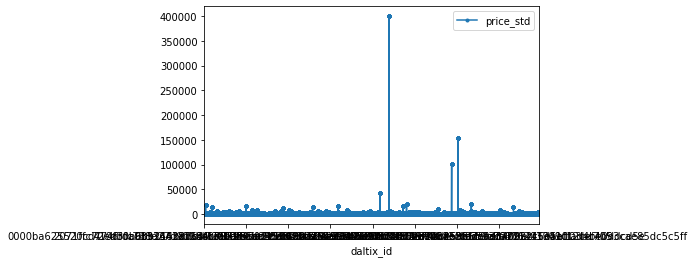

In [6]:
## Check for outliers:

## Check for outliers visually by finding the standard deviation by 'daltix_id':
find_outliers_tab = price_tab[['daltix_id', 'location', 'price', 'date']].copy().drop_duplicates(keep='first')
stdeviations = find_outliers_tab.groupby('daltix_id').std()

## Add price standard deviation as 'price_std' to the table 'find_outliers_tab' and 'price_tab':
stdeviations.columns = stdeviations.columns + '_std'
find_outliers_tab = pd.merge(find_outliers_tab, stdeviations.price_std, how='outer', on=['daltix_id'])
price_tab = pd.merge(price_tab, stdeviations.price_std, how='outer', on=['daltix_id'])

## Plot 'price_std' per 'daltix_id':
find_outliers_tab.plot(x="daltix_id", y="price_std", marker='.')

In [7]:
## Define metrics to delete outliers:

## See different price entries introduced per daltix_id:
find_outliers_tab.groupby('daltix_id')['price'].unique()

## Find number of unique price entries per daltix_id:
price_per_daltix_id = find_outliers_tab[['daltix_id', 'price']].copy().drop_duplicates(keep='first')
price_nrprices_tab = price_per_daltix_id.groupby('daltix_id')['price'].count().to_frame('nr_prices').reset_index()
price_nrprices_tab.sort_values(by='daltix_id')

## Are any prices wrongly introduced/registered? See the number of price entries per different 'price' per 'daltix_id':
daltix_ids = find_outliers_tab.daltix_id.unique()
price_entries_tab = find_outliers_tab.groupby(['daltix_id', 'price'])['price'].count().to_frame('price_entries').reset_index()
price_entries_tab.sort_values(by='daltix_id')

## Add 'price_entries' column and 'nr_prices' to price_tab:
price_tab_2 = pd.merge(price_tab, price_entries_tab, how='outer', on=['daltix_id', 'price'])
price_tab_3 = pd.merge(price_tab_2, price_nrprices_tab, how='outer', on=['daltix_id'])

## Change 'price_entries' and 'nr_prices' columns into integers:
price_tab_3.price_entries = price_tab_3.price_entries.astype(int)
price_tab_3.nr_prices = price_tab_3.nr_prices.astype(int)

## Eliminate Outliers - vals introduced <=3x when >1 prices have been introduced for a particular 'daltix_id':
outliers = price_tab_3[(price_tab_3.nr_prices>1) & (price_tab_3.price_entries<=3)]
price_tab_outliersfree = price_tab_3[~((price_tab_3.nr_prices>1) & (price_tab_3.price_entries<=3))]

## Check:
#pd.set_option('display.max_rows', price_tab_outliersfree.shape[0]+1)
#price_tab_outliersfree[price_tab_outliersfree.product_id.isin(['S2019080600288050000'])].sort_values(by='price')

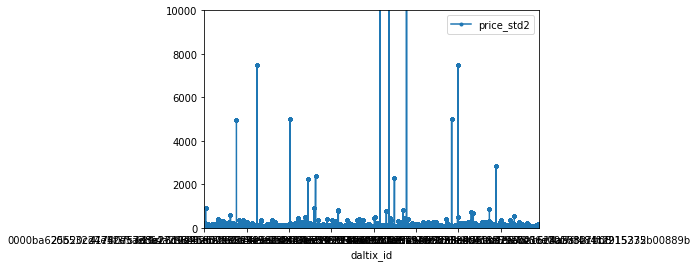

In [8]:
## Check for outliers after first metrics was applied:

## Check for outliers a second time visually by finding the standard deviation by 'daltix_id':
find_outliers_tab = price_tab_outliersfree[['daltix_id', 'location', 'price', 'date']].copy().drop_duplicates(keep='first')
stdeviations = find_outliers_tab.groupby('daltix_id').std()

## Add price standard deviation as 'price_std' to the table 'find_outliers_tab':
stdeviations.columns = stdeviations.columns + '_std2'
find_outliers_tab = pd.merge(find_outliers_tab, stdeviations.price_std2, how='outer', on=['daltix_id'])
price_tab = pd.merge(price_tab, stdeviations.price_std2, how='outer', on=['daltix_id'])
#price_tab_outliersfree = pd.merge(price_tab_outliersfree, stdeviations.price_std2, how='outer', on=['daltix_id']) APAGAR

## Plot 'price_std' per 'daltix_id':
find_outliers_tab.plot(x="daltix_id", y="price_std2", marker='.', ylim=[0,10000])

### 1.3 - Category Table

##### Main Issues Detected
- Field "categories" - separate into 'main_category', 'sub_category_1', 'sub_category_2'

- Field 'main_category' - has different levels of main category (promotion category is very different from a product type category). Only shop1 has main categories that are not product type, and all shop1's  main categories are not product type.
    - e.g.1: 'Aanbiedingen' vs. 'Dranken'
    
- Field "main_category" - lacks standardisation
    - e.g.1: 'Wijn & Bubbels' vs. 'Wijn en Bubbels'
    - e.g.2: 'Brood / Ontbijt' vs. 'Brood/Ontbijt'
    

##### Clean Table

In [9]:
## Standardize column 'categories' in category_tab:
category_tab['categories'] = category_tab['categories'].str.lower()
category_tab.categories = category_tab.categories.apply(lambda x: x.replace(' / ', '/') if isinstance(x, str) else x)
category_tab.categories = category_tab.categories.apply(lambda x: x.replace('&', 'en') if isinstance(x, str) else x)
category_tab.categories = category_tab.categories.apply(lambda x: x.replace('  ', ' ') if isinstance(x, str) else x)

## Split 'categories' column into 3 columns (n=2):
category_split = category_tab["categories"].str.split(",", n = 2, expand = True) 

## Clean each new column by selecting text between "":
category_split_0 = category_split[0].str.split("\"", n = 2, expand = True)
category_split_1 = category_split[1].str.split("\"", n = 2, expand = True)
category_split_2 = category_split[2]

## Give new columns the names 'main_category', 'sub_category_1', 'subsub_categories', and add them to 'category_tab' table:
category_tab["main_category"]= category_split_0[1]
category_tab["sub_category_1"]= category_split_1[1]
category_tab["subsub_categories"]= category_split_2

## Analyze each shop categories:
#category_tab.main_category[category_tab.shop == 'shop1'].value_counts().plot.pie()
#print(category_tab.main_category[category_tab.shop == 'shop1'].sort_values().unique())

## Separate category data from shop1 to a different table (category_tab_shop1):
category_tab_shop1 = category_tab[category_tab.shop == 'shop1'].copy()
category_tab = category_tab[category_tab.shop != 'shop1'].copy()

### 1.4 - Promo Table

##### Main Issues Detected

- Field "dlevel" - highly scattered

    - Most discount values were in the [0,1] range. However, some instances were in the [0,100] range (probably introduced as percentages). These values were normalized and used in the analysis.
    
    - Discounts over 0.75 do not exist, as expected and only one item from shop3 has dlevels over 0.5, in both 'ledeberg' and 'ans' locations.

##### Clean Table

In [10]:
## Check unique discount values 'dlevel':
promo_tab.dlevel.sort_values().unique()

## Check number of discount values > 1 (these were probably introduced as percentages):
promo_tab[promo_tab.dlevel > 1]

## Normalize dlevels introduced as percentages:
promo_tab.loc[promo_tab['dlevel'] > 1, 'dlevel'] = promo_tab['dlevel'] * 0.01

## Does the maximum dlevel make sense? Over 0.5 is a very big discount.
#promo_tab[promo_tab.dlevel > 0.5]

In [ ]:
# code here

_____________________
## 2. Explore the dataset

**Requirements:**
Use `pandasql` to query the tables and explore the dataset

**Description**

In this section you are free to explore the data however you like in order get to know your dataset. It's meant to be exploratory and only for you to get familiar with the data.

At the end of this section you should be able to, at least, answer the following questions:
* For which time interval you have prices for?
* How many shops are comprised in the dataset?
* How many different products are there per shop in the dataset?
* Can a product have more than 1 active promotion at the same time? 

You are free (and __encouraged__) to further describe the dataset as you see fit.

In [11]:
def pysqldf(query):
 return ps.sqldf(query, globals())

### 2.1 - For which time interval you have prices for?

- From 2019-08-01 until 2019-10-15

Owner Note: It was necessary to use pandas due to large file dimensions. Otherwise PC would crash.


In [12]:
## USING PANDASQL: 

#q_sort_price_date = """
#SELECT DISTINCT price, date
#FROM price_tab
#WHERE price AND date IS NOT NULL
#ORDER BY [date];
#"""
#sort_price_date = pysqldf(q_sort_price_date)
#print(sort_price_date.head())
#print(sort_price_date.tail())

In [13]:
## USING PANDAS: 

#price_tab.sort_values(by='date')
print("ti: " + str(price_tab.date.min()))
print("tf: " + str(price_tab.date.max()))

ti: 2019-08-01
tf: 2019-10-15


### 2.2 - How many shops are comprised in the dataset?

- Product/Price Tables: 4 shops (Shop1, Shop2, Shop3, Shop4)
- Promo Table: 3 shops (Shop2, Shop3, Shop4)
- Category Table: 3 shops (Shop2, Shop3, Shop4) + Shop1, previously eliminated from this table

Owner Note: It was necessary to use pandas for the price file, due to large file dimensions. Otherwise PC would crash.


In [14]:
## USING PANDASQL: 

    ## Product Dataset
q_nr_shops_product_tab = """
SELECT DISTINCT product_tab.shop
FROM product_tab;
"""
print("Nr of shops in Product Table: " + str(len(pysqldf(q_nr_shops_product_tab))))
#print(pysqldf(q_nr_shops_product_tab).sort_values(by='shop'))

    ## Category Dataset
q_nr_shops_category_tab = """
SELECT DISTINCT category_tab.shop
FROM category_tab;
"""
print("Nr of shops in Category Table: " + str(len(pysqldf(q_nr_shops_category_tab))))
#print(pysqldf(q_nr_shops_category_tab).sort_values(by='shop'))

    ## Promo Dataset
q_nr_shops_promo_tab = """
SELECT DISTINCT promo_tab.shop
FROM promo_tab;
"""
print("Nr of shops in Promo Table: " + str(len(pysqldf(q_nr_shops_promo_tab))))
#print(pysqldf(q_nr_shops_promo_tab).sort_values(by='shop'))

    ## Price Dataset
#q_nr_shops_price_tab = """
#SELECT DISTINCT price_tab.shop
#FROM price_tab;
#"""
#print("Nr of shops in Price Table: " + str(len(pysqldf(q_nr_shops_price_tab))))

Nr of shops in Product Table: 4
Nr of shops in Category Table: 3
Nr of shops in Promo Table: 3


In [15]:
## USING PANDAS: 

    ## Price Dataset
nr_shops_price_tab = price_tab.shop.unique()

print("Nr of shops in Price Table: " + str(len(nr_shops_price_tab)))
#print(sorted(price_tab.shop.unique()))

Nr of shops in Price Table: 4


### 2.3 - How many different products are there per shop in the dataset?

##### 2.3 - Main Issues Detected

- Question: Is there a unique product_id for each daltix_id?

    - Answer: NO. There are more daltix_ids than product_ids.
        - Is it because daltix_id(product_id, shop, country)? Does this happen only when the shop is in > 1 country? YES
        
(See code below)

In [16]:
shops = product_tab.shop.sort_values().unique()

## Print unique values per shop, to understant if there is overlap between identifying variables:

print('\nUnique Entries:') 
print('Shops \t country \t daltix_id \t product_id \t name') 
for i in range(len(shops)):
    print(str(shops[i]) + '\t' + str(len(product_tab.country[product_tab.shop == shops[i]].unique())) +
          '\t\t' + str(len(product_tab.daltix_id[product_tab.shop == shops[i]].unique())) +
          '\t\t' + str(len(product_tab.product_id[product_tab.shop == shops[i]].unique())) +
          '\t\t' + str(len(product_tab.name[product_tab.shop == shops[i]].unique())))
    
print('\nUnique daltix_ids per table:')
print('Shop \t Product_tab \t Price_tab \t Promo_tab \t Category_tab')
for i in range(len(shops)):
    print(str(shops[i]) + ' \t ' +  str(len(product_tab.daltix_id[product_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(price_tab.daltix_id[price_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(promo_tab.daltix_id[promo_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(category_tab.daltix_id[category_tab.shop == shops[i]].unique())))


Unique Entries:
Shops 	 country 	 daltix_id 	 product_id 	 name
shop1	2		2010		1896		1901
shop2	1		6		6		6
shop3	1		807		807		794
shop4	1		1369		1369		1363

Unique daltix_ids per table:
Shop 	 Product_tab 	 Price_tab 	 Promo_tab 	 Category_tab
shop1 	 2010		5487		0		0
shop2 	 6		17996		3		4
shop3 	 807		9432		115		593
shop4 	 1369		17788		232		765


- Question: Can a shop have >1 products associated to the same product_id?

    - Answer: YES. There are products within a shop with the same product_id that are very different products and have a different name! This can happen if the shop exists in different countries. In this case the variable "daltix_id" solves it. (e.g.2.3.1)
    

- Question: Can different shops have  products associated to the same product_id?

    - Answer: YES. There are products from different shops that have the same product_id. They might even be similar products with names written slightly differently. In this case it does not affect the product count per shop. (e.g.2.3.2)
    
    
- Question: Can a shop have >1 products with the same name identified with different product_id's?

    - Answer: YES. There are products within a shop with the same name that have different product_ids (both in the same country and in different countries)! In these cases the same product can be considered >1 time. (e.g.2.3.3 and e.g.2.3.4)
    
(See code below)   

In [17]:
shops = product_tab.shop.sort_values().unique()
shop_assortment = product_tab[['shop', 'country', 'product_id', 'name']].copy().drop_duplicates(keep='first')

## Find examples of duplicate product_ids: 
duplicate_product_id = pd.concat(g for _, g in shop_assortment.groupby("product_id") if len(g) > 1)
duplicate_names = pd.concat(g for _, g in shop_assortment.groupby("name") if len(g) > 1)

print('\nExample 2.3.1: ')
print(duplicate_product_id[duplicate_product_id.product_id == '1270'])

print('\nExample 2.3.2: ')
print(duplicate_product_id[duplicate_product_id.product_id == '10315'])

print('\nExample 2.3.3: ')
print(duplicate_names[duplicate_names.name == 'aardappelsalade 500g'])

print('\nExample 2.3.4: ')
print(duplicate_names[duplicate_names.name == 'advocaat'])


Example 2.3.1: 
      shop country product_id                name
455  shop1      be       1270    hondenpoepzakjes
547  shop1      nl       1270  italiaanse burgers

Example 2.3.2: 
       shop country product_id                                      name
307   shop3      be      10315       boni s. fruitcockt.lichte sir. blik
1390  shop4      be      10315  boni s. fruitcockt.lichte sir. blik 227g

Example 2.3.3: 
       shop country product_id                  name
249   shop4      be      10288  aardappelsalade 500g
1445  shop4      be      29189  aardappelsalade 500g

Example 2.3.4: 
       shop country product_id      name
585   shop1      nl       1131  advocaat
1848  shop1      be       4237  advocaat


In [18]:
## USING PANDASQL: 

    ## Shop1:
q_products_shop1 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop1';
"""
print('Product Table - shop1:\n' + str(pysqldf(q_products_shop1)))

    ## Shop2:
q_products_shop2 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop2';
"""
print('Product Table - shop2:\n' + str(pysqldf(q_products_shop2)))

    ## Shop3:
q_products_shop3 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop3';
"""
print('Product Table - shop3:\n' + str(pysqldf(q_products_shop3)))

    ## Shop4:
q_products_shop4 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop4';
"""
print('Product Table - shop4:\n' + str(pysqldf(q_products_shop4)))

Product Table - shop1:
   COUNT(DISTINCT daltix_id)
0                       2010
Product Table - shop2:
   COUNT(DISTINCT daltix_id)
0                          6
Product Table - shop3:
   COUNT(DISTINCT daltix_id)
0                        807
Product Table - shop4:
   COUNT(DISTINCT daltix_id)
0                       1369


### 2.4 - Can a product have more than 1 active promotion at the same time?

- YES. A product from a specific shop can have different promotions at different locations and at the same location! (e.g.2.4.1)

In [19]:
## USING PANDASQL:

# Item simultaneous promotions at a specific shop at a specific location:
q_simultaneous_promos = """
SELECT COUNT (DISTINCT promo_type) AS promo_nr
FROM promo_tab
GROUP BY daltix_id, date, shop, location
ORDER BY promo_nr DESC;
"""

print('Maximum number of simultaneous promotions:')
print(pysqldf(q_simultaneous_promos).max())

Maximum number of simultaneous promotions:
promo_nr    2
dtype: int64


In [20]:
## Extra Check 1 USING PANDAS:

promo_tab_2 = promo_tab.copy()

# Product simultaneous promos: a new field is required (daltix_id + date)
promo_tab_2['daltix_id_date'] = promo_tab_2['daltix_id'] + '_' + promo_tab_2['date']
simultaneous_promo = promo_tab_2.groupby('daltix_id_date')['promo_type'].count().to_frame('nr_promos').reset_index()
print(simultaneous_promo.nr_promos.unique())
simultaneous_promo_ids = list(simultaneous_promo.daltix_id_date[simultaneous_promo.nr_promos == 4])

# This reflects different types of promotions with different dlevels, at different location:
print('Example 2.4.1:')
promo_tab_2[promo_tab_2['daltix_id_date'].isin(simultaneous_promo_ids[0:1])].sort_values(by='date')

[1 2 4]
Example 2.4.1:


,daltix_id,shop,country,location,promo_type,dlevel,date,daltix_id_date
1279,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ledeberg,Price cut with Multibuy Condition,0.357143,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...
2617,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ans,Price cut with Multibuy Condition,0.251256,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...
2844,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ledeberg,Price cut,0.714286,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...
4177,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ans,Price cut,0.502513,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...


##### 2.4 - Main Issues Detected

- Rounding of the variable 'dlevel' issue (e.g.2.4.2)

(see code below)

In [21]:
## Extra Check 2 USING PANDAS:

# Product simultaneous promos at a specific shop at a specific location:
promo_tab_2['daltix_id_date_shop_location'] = promo_tab_2['daltix_id'] + '_' + promo_tab_2['date'] + '_' + promo_tab_2['shop'] + '_' + promo_tab_2['location']
simultaneous_promo = promo_tab_2.groupby('daltix_id_date_shop_location')['promo_type'].count().to_frame('nr_promos').reset_index()
print(simultaneous_promo.nr_promos.unique())
simultaneous_promo_ids = list(simultaneous_promo.daltix_id_date_shop_location[simultaneous_promo.nr_promos == 2])

# This reflects different types of promotions:
promo_tab_2[promo_tab_2['daltix_id_date_shop_location'].isin(simultaneous_promo_ids[35:36])].sort_values(by='date')

# This reflects round(dlevel) issue:
print('Example 2.4.2:')
promo_tab_2[promo_tab_2['daltix_id_date_shop_location'].isin(simultaneous_promo_ids[0:1])].sort_values(by='date')

[1 2]
Example 2.4.2:


,daltix_id,shop,country,location,promo_type,dlevel,date,daltix_id_date,daltix_id_date_shop_location
1964,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,shop2,be,base,Price cut with Multibuy Condition,0.333333,2019-09-12,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...
4014,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,shop2,be,base,Price cut with Multibuy Condition,0.330000,2019-09-12,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...


In [22]:
## Round discount level:
promo_tab.dlevel = promo_tab.dlevel.round(2)

## Eliminate duplicate rows:
promo_tab = promo_tab.drop_duplicates(keep='first')

___________________________
## 3 Transformation & Manipulation

__Description__

In this section you should use the tables provided in the dataset and manipulate them to find valuable business insights.

Some questions you should be able to answer:
* Which shops have a bigger overlap in their assortment?
* Which shop has the overall cheapest assortment? What about cheapest categories?
* Which shop is the "_king_" of promotions?
* Where would you do your shopping? When? Why?
* Can you spot any weird price behaviour? 

The questions above are just some example questions. You should provide any insights you find useful/relevant.

_Note:_
* Use this section as a prepation for the next!

### 3.1 - Which shops have a bigger overlap in their assortment?

- Shops 3 and 4

In [23]:
## Create new table to find assortment Overlap:
shop_assortment = product_tab[['shop', 'country', 'product_id', 'name']].copy().drop_duplicates(keep='first')

##### Main Issues Detected

- There are several articles in the same shop and location with different product_id (e.g.3.1.1).
    - They might be the same product or not.

In [24]:
print('Example 3.1.1:')
shop_assortment[shop_assortment.name.isin(['olijven', 'zitbank met opbergruimte'])].sort_values(by='name')

Example 3.1.1:


,shop,country,product_id,name
2609,shop1,be,5567,olijven
3331,shop1,nl,7218,olijven
3927,shop1,be,4375,olijven
1317,shop1,be,7840,zitbank met opbergruimte
3531,shop1,be,6116,zitbank met opbergruimte


- Some products from different shops might be the same but are not identified in the same way (e.g.3.1.2).

In [25]:
print('Example 3.1.2:')
shop_assortment[(shop_assortment.name.str.contains('corblokken houtblokken')) |
                (shop_assortment.name.str.contains('lemmens bbq td'))].sort_values(by='name')

Example 3.1.2:


,shop,country,product_id,name
2581,shop3,be,3570000,corblokken houtblokken 11dm¿
2978,shop4,be,15912,corblokken houtblokken 11dm¿ 8kg
793,shop3,be,3283575,devos lemmens bbq td
3544,shop4,be,8179,devos lemmens bbq td 300ml


##### Assumptions

- Products from the same shop with different 'product_ids' will be considered the same (no matter the country). These column will not be used.

- Products from different shops with similar names will be regarded as different.

Shops 1 and 2 have 0 common items.
Shops 1 and 3 have 6 common items.
Shops 1 and 4 have 2 common items.
Shops 2 and 3 have 0 common items.
Shops 2 and 4 have 0 common items.
Shops 3 and 4 have 69 common items.


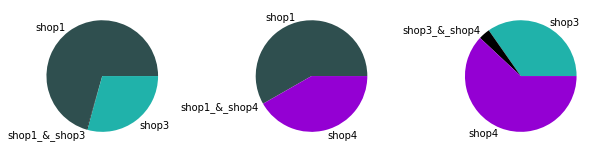

In [26]:
## Assortment Overlap between each shop:
shop_assortment = shop_assortment[['shop', 'name']].copy().drop_duplicates(keep='first')

assortment_overlap_12 = shop_assortment[shop_assortment.shop.isin(['shop1', 'shop2'])].sort_values(by='name')
assortment_overlap_13 = shop_assortment[shop_assortment.shop.isin(['shop1', 'shop3'])].sort_values(by='name')
assortment_overlap_14 = shop_assortment[shop_assortment.shop.isin(['shop1', 'shop4'])].sort_values(by='name')
assortment_overlap_23 = shop_assortment[shop_assortment.shop.isin(['shop2', 'shop3'])].sort_values(by='name')
assortment_overlap_24 = shop_assortment[shop_assortment.shop.isin(['shop2', 'shop4'])].sort_values(by='name')
assortment_overlap_34 = shop_assortment[shop_assortment.shop.isin(['shop3', 'shop4'])].sort_values(by='name')

print('Shops 1 and 2 have ' + str(len(assortment_overlap_12.name) - len(assortment_overlap_12.name.unique())) + ' common items.')
print('Shops 1 and 3 have ' + str(len(assortment_overlap_13.name) - len(assortment_overlap_13.name.unique())) + ' common items.')
print('Shops 1 and 4 have ' + str(len(assortment_overlap_14.name) - len(assortment_overlap_14.name.unique())) + ' common items.')
print('Shops 2 and 3 have ' + str(len(assortment_overlap_23.name) - len(assortment_overlap_23.name.unique())) + ' common items.')
print('Shops 2 and 4 have ' + str(len(assortment_overlap_24.name) - len(assortment_overlap_24.name.unique())) + ' common items.')
print('Shops 3 and 4 have ' + str(len(assortment_overlap_34.name) - len(assortment_overlap_34.name.unique())) + ' common items.')

## Assortment Overlap between 1 and 3:
assortment_overlap_13 = shop_assortment[shop_assortment.shop.isin(['shop1', 'shop3'])].sort_values(by='name')

for name in assortment_overlap_13.name.unique():
    if len(assortment_overlap_13[assortment_overlap_13.name == name]) > 1:
        assortment_overlap_13.shop[assortment_overlap_13.name == name] = 'shop1_&_shop3'

assortment_overlap_13 = assortment_overlap_13.drop_duplicates(keep='first')
overlap13 = assortment_overlap_13.groupby(['shop'])['name'].count().to_frame('name_count').reset_index()

## Assortment Overlap between 1 and 4:
assortment_overlap_14 = shop_assortment[shop_assortment.shop.isin(['shop1', 'shop4'])].sort_values(by='name')

for name in assortment_overlap_14.name.unique():
    if len(assortment_overlap_14[assortment_overlap_14.name == name]) > 1:
        assortment_overlap_14.shop[assortment_overlap_14.name == name] = 'shop1_&_shop4'

assortment_overlap_14 = assortment_overlap_14.drop_duplicates(keep='first')
overlap14 = assortment_overlap_14.groupby(['shop'])['name'].count().to_frame('name_count').reset_index()

## Assortment Overlap between 3 and 4:
assortment_overlap_34 = shop_assortment[shop_assortment.shop.isin(['shop3', 'shop4'])].sort_values(by='name')

for name in assortment_overlap_34.name.unique():
    if len(assortment_overlap_34[assortment_overlap_34.name == name]) > 1:
        assortment_overlap_34.shop[assortment_overlap_34.name == name] = 'shop3_&_shop4'

assortment_overlap_34 = assortment_overlap_34.drop_duplicates(keep='first')
overlap34 = assortment_overlap_34.groupby(['shop'])['name'].count().to_frame('name_count').reset_index()

## Plot Assortment Overlaps:
colors13 = ['darkslategrey','black','lightseagreen']
colors14 = ['darkslategrey','black', 'darkviolet']
colors34 = ['lightseagreen','black','darkviolet']
fig_assortment_overlap, (ax13, ax14, ax34) = plt.subplots(1,3, figsize=(10,40))
plt.subplots_adjust(wspace=0.5)
ax13.pie(overlap13.name_count, labels=overlap13.shop, colors=colors13)
ax14.pie(overlap14.name_count, labels=overlap14.shop, colors=colors14)
ax34.pie(overlap34.name_count, labels=overlap34.shop, colors=colors34)
plt.show()

### 3.2 - Which shop has the overall cheapest assortment?

- Cost of assortment: shop1 < shop3 < shop4 < shop2.

In [27]:
## Find cheapest Assortment (only unique prices per daltix_id are required:
cheapest_assortment_tab = price_tab_outliersfree[['daltix_id', 'shop', 'price']].copy().drop_duplicates(keep='first')

cheapest_assortment = cheapest_assortment_tab.groupby('shop')['price'].mean().to_frame('assortment_price_avg').reset_index()
cheapest_assortment

,shop,assortment_price_avg
0,shop1,7.075549
1,shop2,20.774783
2,shop3,10.080059
3,shop4,12.365223


### 3.3 - Which shop has the overall cheapest categories?

Owner Note: In section 1.3 all data from shop1 was excluded from the category table, as all categories mentioned were related to promotions and not products. This shop is excluded from this analysis.

- Cheapest Categories:
    - 1º) conserven en soepen (category_price_avg: 4.07€)
        - shop3      
    - 2ª) kruidenierswaren/droge voeding (category_price_avg: 4.44€)
        - shop4 and shop3 (category_price_avg of shop4 is lower)
    - 3º) groenten en fruit (category_price_avg: 4.44€)
        - shop4 and shop3 (category_price_avg of shop4 is lower)
    
    
- Most Expensive Categories:
    - 1º) lichaamsverzorging/parfumerie (category_price_avg: 28.01€)
        - shop4 and shop3 (category_price_avg of shop4 is higher)
    - 2ª) colruyt-beenhouwerij (category_price_avg: 10.89€)
        - shop4 and shop3 (category_price_avg of shop4 is higher) 
    - 3º) dieetvoeding/voedingssupplementen (category_price_avg: 10.66€)
        - shop4 and shop3 (category_price_avg of shop4 is higher)

    
- Issues found:
    - Ex: There are products that cost too much fo the category they're at. Ex: in the groenten en fruit category there is a product that cost > 100€. This is strange.


Cheapest Categories:                      main_category  category_price_avg
8              conserven en soepen            4.070286
12               groenten en fruit            4.351534
16  kruidenierswaren/droge voeding            4.413653

Most expensive Categories:                         main_category  category_price_avg
9   dieetvoeding/voedingssupplementen           10.660238
6                colruyt-beenhouwerij           10.851369
17      lichaamsverzorging/parfumerie           28.101429


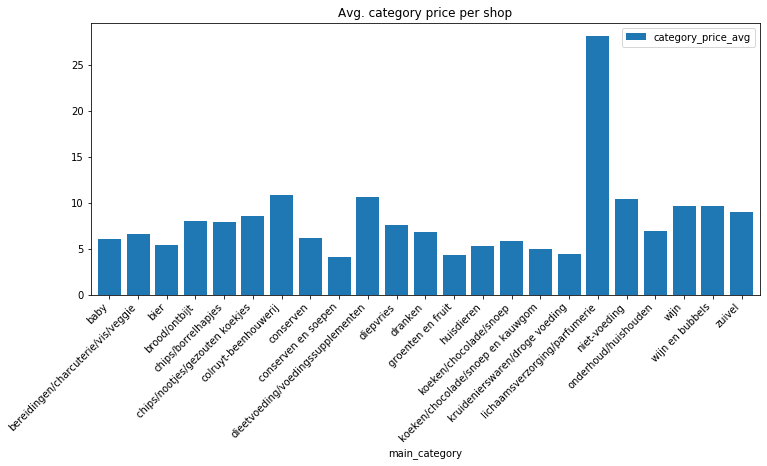

In [28]:
## Merge price and category tables:
categoryprice_tab = pd.merge(category_tab, price_tab_outliersfree, how='inner', on=['daltix_id', 'shop', 'country'])

## Select columns of interest ('daltix_id','shop','main_category','price') to drop price duplicates (which occur for each date):
categoryprice_tab_2 = categoryprice_tab[['daltix_id','shop','main_category','price','price_entries','nr_prices']].copy().drop_duplicates(keep='first')

## Determine average cost of products in each 'main_category' (all shop prices included):
cheapest_categories = categoryprice_tab_2.groupby(['main_category'])['price'].mean().to_frame('category_price_avg').reset_index()
print('Cheapest categories: ')
print(str(cheapest_categories.sort_values(by='category_price_avg')[:3]))
print('Most expensive categories: ')
print(str(cheapest_categories.sort_values(by='category_price_avg')[-3:]))

categories = cheapest_categories.main_category.sort_values().unique()

## Plot avg. category price per shop:
loc = range(len(categories))
labels = categories
fig_category_avgprice, ax = plt.subplots(figsize=(12,5))
cheapest_categories.plot.bar(ax=ax, x='main_category', y='category_price_avg', alpha=1, title='Avg. category price per shop', width=0.8)
plt.xticks(loc, labels, rotation=45, horizontalalignment='right')
plt.show()

## Extra check - See most expensive products 
#categoryprice_tab_2[categoryprice_tab_2.price > 100]

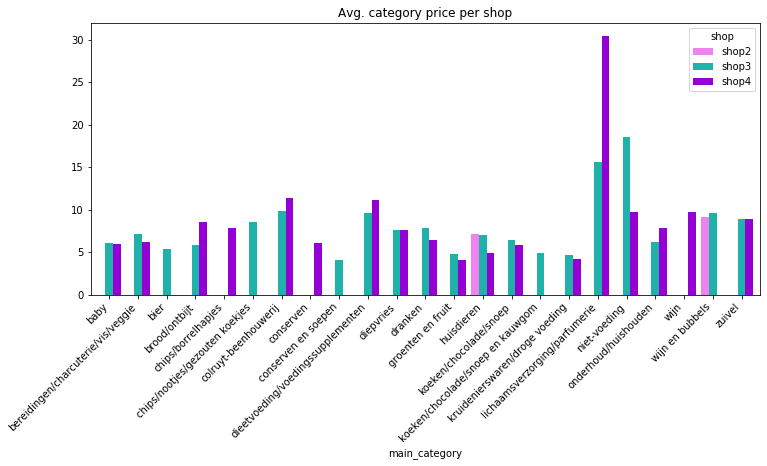

In [29]:
## Determine average cost of products in each 'main_category' per shop:
cheapest_categories_pershop = categoryprice_tab_2.groupby(['shop', 'main_category'])['price'].mean().to_frame('category_price_avg').reset_index()
cheapest_categories_pershop.sort_values(by='category_price_avg')

## Plot average category prices per shop:
categories = cheapest_categories_pershop.main_category.sort_values().unique()

## Plot avg. category price per shop:
loc = range(len(categories))
labels = categories
colors234 = ['violet','lightseagreen', 'darkviolet']
fig_category_price, ax = plt.subplots(figsize=(12,5))
#cheapest_categories_pershop.groupby(['main_category','shop']).sum()['category_price_avg'].unstack().plot(ax=ax, alpha=1, marker='o', title='Avg. category price per shop', colors=colors234)
cheapest_categories_pershop.groupby(['main_category','shop']).sum()['category_price_avg'].unstack().plot.bar(ax=ax, alpha=1, title='Avg. category price per shop', color=colors234, width=0.8)
plt.xticks(loc, labels, rotation=45, horizontalalignment='right')
plt.show()

### 3.4 - Which shop is the "king" of promotions?

- The promo table only has data from shops 2, 3 and 4. These were the ones considered in the section below.

- shop4 is the one with a higher absolute number of promotions, still maintaining an average discount level. In August shop4 has aprox 4 times more products with discount than shop3.

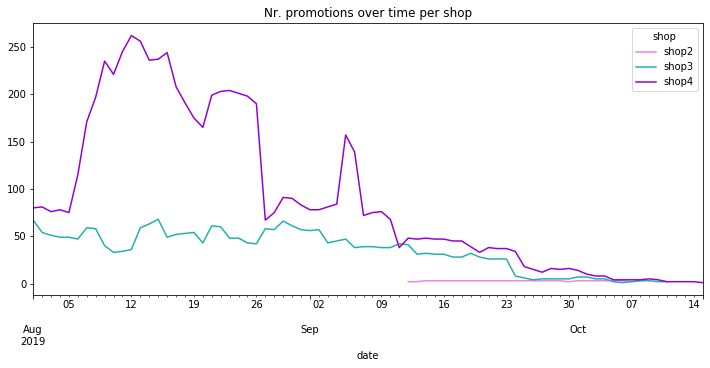

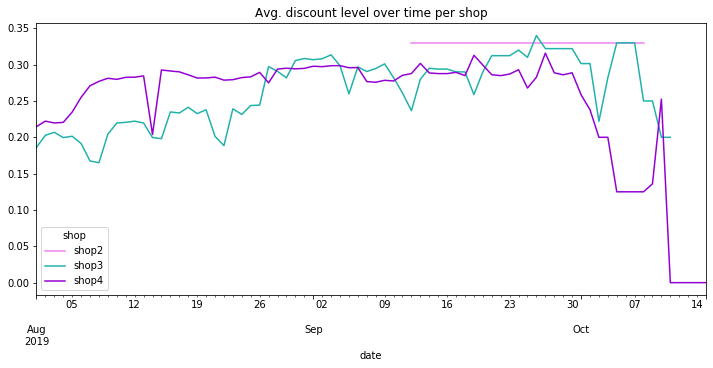

In [30]:
## Create new table to study the number of promotions per shop:
shop_promotions_tab = promo_tab.copy()

## Change "date" type:
shop_promotions_tab['date'] = pd.to_datetime(shop_promotions_tab['date']) #format='%Y/%m/%d'


colors234 = ['violet','lightseagreen', 'darkviolet']

## Plot number of promotions per shop over time:
fig_nr_promotions, ax = plt.subplots(figsize=(12,5))
shop_promotions_tab.groupby(['date','shop']).count()['dlevel'].unstack().plot(ax=ax, alpha=1, title='Nr. promotions over time per shop', color=colors234)
plt.show()

## Plot average discount level per shop over time:
fig_avgdlevel_promotions, ax = plt.subplots(figsize=(12,5))
shop_promotions_tab.groupby(['date','shop']).mean()['dlevel'].unstack().plot(ax=ax, alpha=1, title='Avg. discount level over time per shop', color=colors234)
plt.show()

##### Extra:

The categories table contained info about promotions held by shop1. This info can be also taken into consideration.

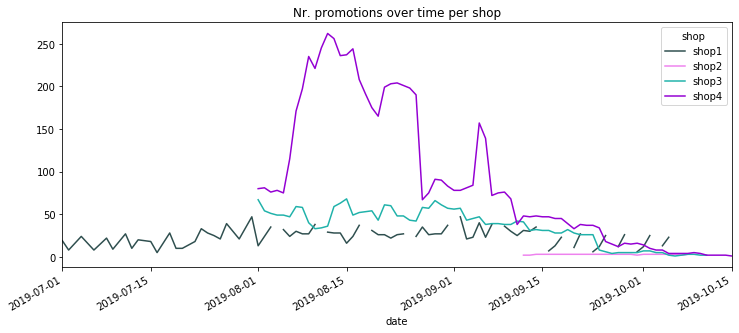

In [31]:
## Consider shop1's promotions stored at the category table:

## Obtain the promotion date from the 'sub_category_1' column (last 5 digits):
category_tab_shop1['date'] = category_tab_shop1.sub_category_1.str[-5:]

## Atribute 'main_category' of category table to 'promo_type'.
category_tab_shop1['promo_type'] = category_tab_shop1['main_category']

## Only some categories are of interest. The others don't even have dates on the last 5 gidits
category_tab_shop1 = category_tab_shop1[category_tab_shop1.promo_type.isin(['onze aanbiedingen', 'aanbiedingen'])]
category_tab_shop1.date = category_tab_shop1.date.apply(lambda x: x.replace('-', '/') if isinstance(x, str) else x)

## Convert dates from both tables to the same format:
category_tab_shop1[['day','month']] = category_tab_shop1["date"].str.split("/", n = 1, expand = True) 
category_tab_shop1['year'] = '2019'
category_tab_shop1['date'] = category_tab_shop1.year + '/' + category_tab_shop1.month + '/' + category_tab_shop1.day
category_tab_shop1['date'] = pd.to_datetime(category_tab_shop1['date'])
promo_tab['date'] = pd.to_datetime(promo_tab['date'])

## Add shop1 promotions to other promos:
shop_promotions_tab_allshops = pd.merge(promo_tab, category_tab_shop1, how='outer', on=['daltix_id', 'shop', 'country', 'date', 'promo_type'])

colors1234 = ['darkslategrey', 'violet','lightseagreen', 'darkviolet']

## Plot nr. promotions per shop over time:
fig, ax = plt.subplots(figsize=(12,5))
shop_promotions_tab_allshops.groupby(['date','shop']).count()['promo_type'].unstack().plot(ax=ax, alpha=1, title='Nr. promotions over time per shop', color=colors1234)
plt.show()

### 3.5 - Where would you do your shopping? When? Why?

- I would buy everyday items in shop4, as this shop offers the lowest average prices for the least expensive categories. The exception is the category bread/breakfast ('brood/ontbijt'), where the prices are aprox 30% cheaper in shop3.


- Items that are necessary in a lower frequency such as perfumes, suplements of maintenance equipment (categories 'lichaamsverzorging/parfumerie', 'dieetvoeding/voedingssupplementen' and 'onderhoud/huishouden') are cheaper in shop3 and there is where I would buy them.


- Shop4 offers many promotions, especially during August, so I would probably try to buy more products then (as long as they are not perishable).

### 3.6 - Can you spot any weird price behaviour?

- It seems some product_ids have more than 1 product linked to it.

In [32]:
## Create new table to better identify weird price behaviour:
price_behaviour = price_tab_outliersfree.copy()
del price_behaviour['date']
del price_behaviour['daltix_id']
price_behaviour = price_behaviour.drop_duplicates(keep='first')

- Example 3.6.1
    - This example shows a product from shop 2 than is only sold in one location only that has 4 prices associated. Before outliers removal it has 5 prices associated, but one was introduced <3times so it was considered an input error.
    - There are still 4 prices, 2 of them introduced 68x over time. These 2 (4.89€ and 1630.00€) are very different, and were many times introduced on the same day, which means there are two very different products in the shop that have the same internal product_id.
    - Prices 5.15€ and 1716.67€ are similar to the other two and could be seen as discount prices were they not higher. They still seem to make sense to the two products linked to product_id 'S2017082304174280000'.

In [33]:
print('Example 3.6.1:')
price_behaviour[price_behaviour.product_id == 'S2017082304174280000']

Example 3.6.1:


,shop,country,product_id,location,price,unit_std,price_std,price_entries,nr_prices
4897875,shop2,be,S2017082304174280000,be,4.89,su,16644.619405,68,5
4897943,shop2,be,S2017082304174280000,be,1630.00,kg,16644.619405,68,5
4898011,shop2,be,S2017082304174280000,be,1716.67,kg,16644.619405,6,5
4898017,shop2,be,S2017082304174280000,be,5.15,su,16644.619405,6,5


- Example 3.6.2
    - Once again, this example show two prodycts linked to the same product_id of shop2.
    - It is not a matter of decimals, since the scale difference is >>100, and the values are so different.
    

In [34]:
print('Example 3.6.2:')
price_behaviour[price_behaviour.product_id == 'S2011091908000160000']

Example 3.6.2:


,shop,country,product_id,location,price,unit_std,price_std,price_entries,nr_prices
1295143,shop2,be,S2011091908000160000,be,7.49,su,7496.753819,70,3
1295213,shop2,be,S2011091908000160000,be,14980.00,kg,7496.753819,76,3


- Example 3.6.3
    - This example shows a more dubious case. There are 3 prices associated to the same product_id of shop3. Prices 1.25€ and 156.25€ are both very frequent. And then there is the price 19531.25€ that seems wrong, but was still introduced 4x, and is associated to two distinct locations. If the outlier criteria removed price_entries equal to 4 it could be removing relevant data as well such as ocasional promotional prices.
    - Other product_id from shop3 with similar results are: '18910', '14157', '6917', '18768' and '18700'

In [35]:
print('Example 3.6.3:')
price_behaviour[(price_behaviour.product_id == '14157') & (price_behaviour.shop == 'shop3')]

Example 3.6.3:


,shop,country,product_id,location,price,unit_std,price_std,price_entries,nr_prices
2555243,shop3,be,14157,ans,1.25,su,2240.058748,150,3
2555245,shop3,be,14157,ledeberg,1.25,su,2240.058748,150,3
2555393,shop3,be,14157,ans,156.25,l,2240.058748,145,3
2555396,shop3,be,14157,ledeberg,156.25,l,2240.058748,145,3
2555538,shop3,be,14157,ledeberg,19531.25,l,2240.058748,4,3
2555540,shop3,be,14157,ans,19531.25,l,2240.058748,4,3


___________________
# 4. Visualization

__Description__

Imagine you are presenting the insights you found to your team, which include fellow data analysts, data scientists and business colleagues.

Present your findings on the insights you've discovered so far. 

### Available Dataset:

- Comprises data from 4 shops, with prices from 2019-08-01 until 2019-10-15.


- There is a different number of unique products in each table (unique 'daltix_id'):

In [36]:
print('Unique daltix_id:')
print('Shop \t Product_tab \t Price_tab \t Promo_tab \t Category_tab')
for i in range(len(shops)):
    print(str(shops[i]) + ' \t ' +  str(len(product_tab.daltix_id[product_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(price_tab.daltix_id[price_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(promo_tab.daltix_id[promo_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(category_tab.daltix_id[category_tab.shop == shops[i]].unique())))

Unique daltix_id:
Shop 	 Product_tab 	 Price_tab 	 Promo_tab 	 Category_tab
shop1 	 2010		5487		0		0
shop2 	 6		17996		3		4
shop3 	 807		9432		115		593
shop4 	 1369		17788		232		765


### Assortment characteristics:

##### 0. Assumptions:

- Products from the same shop with the same 'name' and different 'product_ids' due to location were considered the same.

- Products from different shops that could be the same, but are identified with slightly different names were regarded as different products.

##### 1. Assortment Overlap:

- Shop 2 has unique products that cannot be found in other shops.

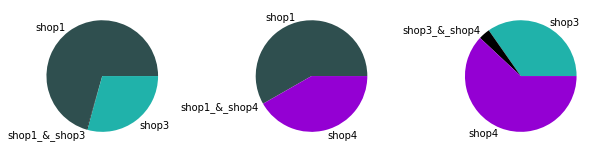

In [37]:
fig_assortment_overlap

##### 2. Assortment Prices:

- Average price per shop:

In [38]:
cheapest_assortment.assortment_price_avg = cheapest_assortment.assortment_price_avg.round(2)
cheapest_assortment

,shop,assortment_price_avg
0,shop1,7.08
1,shop2,20.77
2,shop3,10.08
3,shop4,12.37


- Average price per category:


    - Cheapest Categories:
        - 1º) conserven en soepen (category_price_avg: 4.07€)  
        - 2ª) kruidenierswaren/droge voeding (category_price_avg: 4.44€)
        - 3º) groenten en fruit (category_price_avg: 4.44€)
      
    - Most Expensive Categories:
        - 1º) lichaamsverzorging/parfumerie (category_price_avg: 28.01€)
        - 2ª) colruyt-beenhouwerij (category_price_avg: 10.89€)
        - 3º) dieetvoeding/voedingssupplementen (category_price_avg: 10.66€)
            
    - Shop4 offers the lowest average prices for the least expensive categories.
        - Exception: category bread/breakfast ('brood/ontbijt'), where the prices are aprox 30% cheaper in shop3.
             
    - Items necessary in a lower frequency such as perfumes, suplements of maintenance equipment are cheaper in shop3
        - categories 'lichaamsverzorging/parfumerie', 'dieetvoeding/voedingssupplementen' and 'onderhoud/huishouden'

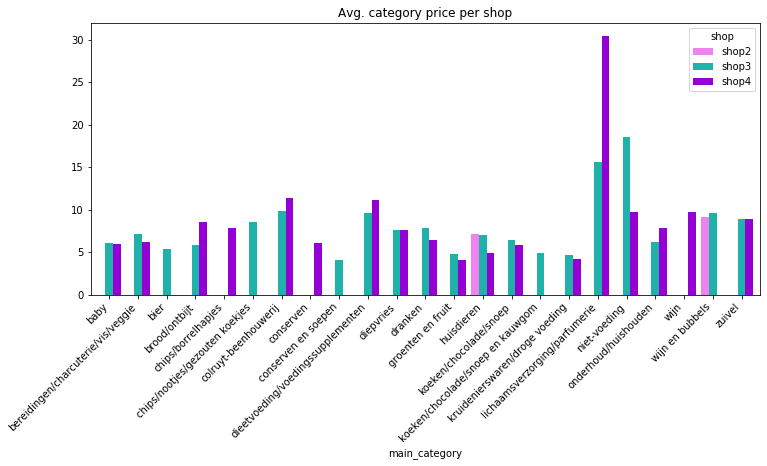

In [39]:
 fig_category_price

##### 3. Promotions:

- A product from a specific shop and location can have simultaneous promotions. (e.g.2.4.1)


- shop4 is the one with a higher absolute number of promotions, still maintaining an average discount level.


- In August shop4 has aproximately 4 times more products with discount than shop3.


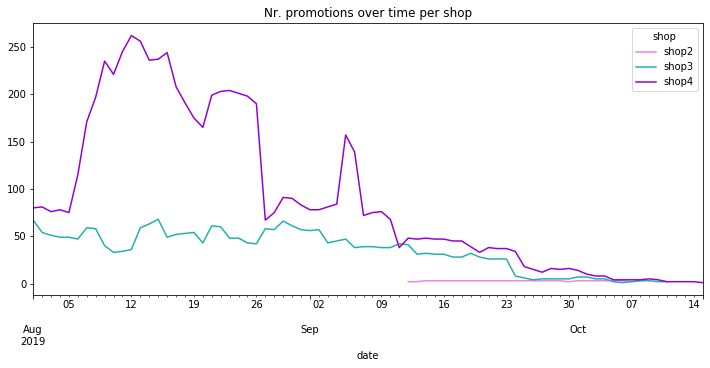

In [40]:
fig_nr_promotions

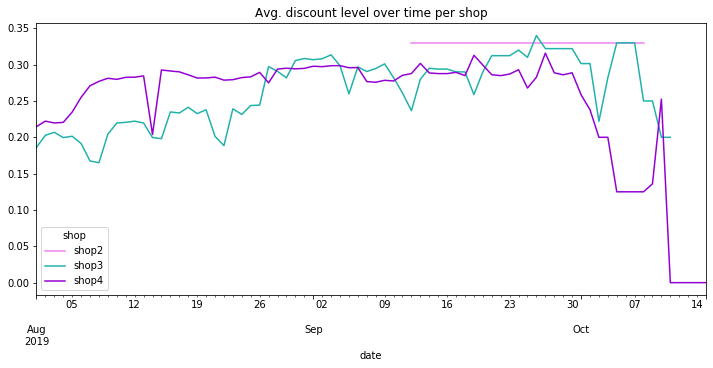

In [41]:
fig_avgdlevel_promotions

##### 4. Main Issues Found:
    
- There are products that cost too much fo the category they're at. Ex: in the groenten en fruit category there is a product that cost > 100€. This is strange.


- Lack of standerdization in categories and products names between shops.


- There are very different products within a shop that share the same product_id. This conclusion comes from the fact that the same product_id can have very different prices being introduced with a high frequency.    

___________________
# 5. Discussion

__Description__

Take some time to prepare some up-coming questions!

* If given more time, how would you further refine your analysis? 
* What other information would you like to have to provide more valuable insigths?

### 5.1 - Discussion:

- Undoubtedly the most important info that is missing is the number of sold items per date, shop, etc. Only with this information can patterns in consumer behaviour be detected, which would help define prices and promotion in the best interest of both consumers and providers.

- Regarding the type of analysis performed, given the chance, I would like to know the total number of different items sold in each shop to present the percentage of items that have discount at a specific date. The number of unique daltix_ids per shop in each table offered was different so I postponed not do this analysis. All the promo analysis could be applied to each location as well.

- It is also important to mention some issues found. A big issue is the fact that some shops' internal product_ids seem to be linked to more than one product. Also, looking closely into the price range of each category some strange results poped up, such as a price of 135.91€ in the 'groenten en fruit' category.

- It would also be great to have more standerdised product names, which seems difficult. I am still trying to figure out the best way to make sense of that specifil column.

___________________
## 6. Bonus question

__Description__

You now have access to the nutritional values of some products:
* **nutri_tbl.csv** - https://daltix-public-interviews.s3-eu-west-1.amazonaws.com/data-analyst-challenge/nutri.csv

Assuming that you have to consume between 2200 kcal and 2700 kcal per day, build a basket of 15 products for a [ketogenic diet](https://en.wikipedia.org/wiki/Ketogenic_diet). Where can we buy that basket for the cheapest price? 

__IMPORTANT__:
This is an extra question that you should only focus one if you have time. 
We will only consider your answer if you solved all the previous sections.

In [42]:
## Import Table:
nutri_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/nutri.csv', sep=',', skip_blank_lines=True)

## Eliminate duplicate rows:
nutri_tab = nutri_tab.drop_duplicates(keep='first')

## Eliminate rows with NaN values in 'nutritional_values' column:
nutri_tab = nutri_tab.dropna(axis=0, subset=['nutritional_values'])

In [43]:
## Split nutritional_values into different categories:

#new = nutri_tab["nutritional_values"].str.split("},", n = 10, expand = True) - DID NOT WORK

carbohydrates1 = nutri_tab["nutritional_values"].str.split("carbohydrates", n = 1, expand = True)
carbohydrates1 = carbohydrates1[1].str.split("value\":", n = 1, expand = True)
carbohydrates1[1] = carbohydrates1[1].str[:5]
carbohydrates2 = carbohydrates1[1].str.split("\n", n = 1, expand = True)
nutri_tab['carbohydrates'] = carbohydrates2[0]

fats1 = nutri_tab["nutritional_values"].str.split("fats", n = 1, expand = True)
fats1 = fats1[1].str.split("value\":", n = 1, expand = True)
fats1[1] = fats1[1].str[:5]
fats2 = fats1[1].str.split("\n", n = 1, expand = True)
nutri_tab['fats'] = fats2[0]

kilocalories1 = nutri_tab["nutritional_values"].str.split("kilocalories", n = 1, expand = True)
kilocalories1 = kilocalories1[1].str.split("value\":", n = 1, expand = True)
kilocalories1[1] = kilocalories1[1].str[:5]
kilocalories2 = kilocalories1[1].str.split("\n", n = 1, expand = True)
nutri_tab['kilocalories'] = kilocalories2[0]

proteins1 = nutri_tab["nutritional_values"].str.split("proteins", n = 1, expand = True)
proteins1 = proteins1[1].str.split("value\":", n = 1, expand = True)
proteins1[1] = proteins1[1].str[:5]
proteins2 = proteins1[1].str.split("\n", n = 1, expand = True)
nutri_tab['proteins'] = proteins2[0]

sugars1 = nutri_tab["nutritional_values"].str.split("sugars", n = 1, expand = True)
sugars1 = sugars1[1].str.split("value\":", n = 1, expand = True)
sugars1[1] = sugars1[1].str[:5]
sugars2 = sugars1[1].str.split("\n", n = 1, expand = True)
nutri_tab['sugars'] = sugars2[0]

portion1 = nutri_tab["nutritional_values"].str.split("portion", n = 1, expand = True)
portion1 = portion1[1].str.split("value\":", n = 1, expand = True)
portion1[1] = portion1[1].str[:5]
portion2 = portion1[1].str.split("\n", n = 1, expand = True)
nutri_tab['portion'] = portion2[0]


## Eliminate rows with NaN values in nutritional values column:
nutri_tab = nutri_tab.dropna(axis=0, subset=['carbohydrates'])
nutri_tab = nutri_tab.dropna(axis=0, subset=['fats'])
nutri_tab = nutri_tab.dropna(axis=0, subset=['kilocalories'])
nutri_tab = nutri_tab.dropna(axis=0, subset=['proteins'])
nutri_tab = nutri_tab.dropna(axis=0, subset=['sugars'])
nutri_tab = nutri_tab.dropna(axis=0, subset=['portion'])


## Change column type:
nutri_tab['carbohydrates'] = pd.to_numeric(nutri_tab['carbohydrates'])
nutri_tab['fats'] = pd.to_numeric(nutri_tab['fats'])
nutri_tab['kilocalories'] = pd.to_numeric(nutri_tab['kilocalories'])
nutri_tab['proteins'] = pd.to_numeric(nutri_tab['proteins'])
nutri_tab['sugars'] = pd.to_numeric(nutri_tab['sugars'])
nutri_tab['portion'] = pd.to_numeric(nutri_tab['portion'])

#Missing energy, fibers, salt, saturated_fats

Based on the state of the art of the Ketogenic diet the following nutrient distribution sould be maintained:

- fats: 70-80%
- carbs: 5-10%
- protein: 20-25%


In [44]:
## Carbs, fats anf proteins percentages:
nutri_tab['carbohydrates_perc'] = nutri_tab['carbohydrates']/(nutri_tab['carbohydrates']+nutri_tab['fats']+nutri_tab['proteins'])
nutri_tab['fats_perc'] = nutri_tab['fats']/(nutri_tab['carbohydrates']+nutri_tab['fats']+nutri_tab['proteins'])
nutri_tab['proteins_perc'] = nutri_tab['proteins']/(nutri_tab['carbohydrates']+nutri_tab['fats']+nutri_tab['proteins'])

## Subseting the nutricional values: (protein values were adjusted by trial and error.)
nutri_tab_ketogenic = nutri_tab[(nutri_tab.carbohydrates_perc < 0.2) &
                 (nutri_tab.fats_perc > 0.7) & (nutri_tab.fats_perc < 0.8) &
                 (nutri_tab.proteins_perc > 0.15) & (nutri_tab.proteins_perc < 0.3)]

## Subseting the 15 products with lowest kilocalories to reach desirable daily intake: 
nutri_tab_ketogenic_diet1 = nutri_tab_ketogenic.sort_values(by='kilocalories')[:15]


## Print nutricional value of chosen basket:
print('Sugar(g): ' + str(nutri_tab_ketogenic_diet1['sugars'].mean()))
print('%Carbs: ' + str(nutri_tab_ketogenic_diet1['carbohydrates_perc'].mean()*100))
print('%Fats: ' + str(nutri_tab_ketogenic_diet1['fats_perc'].mean()*100))
print('%Proteins: ' + str(nutri_tab_ketogenic_diet1['proteins_perc'].mean()*100))
print('kcals: ' + str(nutri_tab_ketogenic_diet1['kilocalories'].sum()))
print('products: ' + str(nutri_tab_ketogenic_diet1['kilocalories'].count()))

print('\nDaltix ids of 15 products chosen:')
print(nutri_tab_ketogenic_diet1.daltix_id)

Sugar(g): 1.5000000000000002
%Carbs: 6.934419765734336
%Fats: 72.14361669970944
%Proteins: 20.921963534556216
kcals: 2505.4
products: 15

Daltix ids of 15 products chosen:
7673     b675319fc0ecd70db305ee2ce50cfd9648040071702932...
2997     69e9ee71db9124e770cbd0e323c9166d28b2824e4c1dc8...
13402    e04e6fa17d45eb5ae59177ed33c95624dc3d155d65a012...
2387     32baa6d3e700cd58971ca7f45fd7acda56ece4dc602a3e...
9859     2aed2421064f827164b8148fe93e62b6002d4662a9fa08...
8264     4a35d82daeae84150a96c06d419ab469c059f2be1dda4d...
15070    a58d9e2d93282c5b29890e4c88ecabf9be32ed31423dbd...
12521    eb9ec51870cd0292bf1efc5b861c25b0e1a0f2ccb83ce6...
15199    220221245b3b0cdead8dd03af0918100aab90bf4c12e63...
2835     82a6cf6d29be27a0896ef864176a09d5f17e8be08d2397...
8697     5f7a587e5d7e2a2955c0a406b8b0c9def6c12aac46251a...
2658     252b5e2c019175eec9829a2956b48bd7be4e6a74004196...
3064     8ebd466816df817d579485b2a011927b98952daf4e03eb...
5147     e24fa0019161049df55f6f56e65696c3cce11ebd5424ba...
46

In [50]:
ketogenic_diet1_price = pd.merge(nutri_tab_ketogenic_diet1, price_tab, how='inner', on=['daltix_id', 'shop', 'product_id', 'country']).drop_duplicates(keep='first')
ketogenic_diet1_price = ketogenic_diet1_price[['daltix_id', 'shop', 'location', 'product_id', 'price']].copy().drop_duplicates(keep='first')

ketogenic_diet1_cheapestprice = ketogenic_diet1_price.copy()
cheapestprice = ketogenic_diet1_cheapestprice.groupby(['daltix_id'])['price'].min()
cheapestprice.columns = ['daltix_id', 'cheapest_price']
ketogenic_diet1_cheapestprice = pd.merge(ketogenic_diet1_cheapestprice, cheapestprice, how='inner', on=['daltix_id', 'price']).drop_duplicates(keep='first')
ketogenic_diet1_cheapestprice

,daltix_id,shop,location,product_id,price
0,b675319fc0ecd70db305ee2ce50cfd9648040071702932...,shop3,ledeberg,3245211,1.71
1,69e9ee71db9124e770cbd0e323c9166d28b2824e4c1dc8...,shop2,be,S2015040200002440000,2.19
2,e04e6fa17d45eb5ae59177ed33c95624dc3d155d65a012...,shop3,ledeberg,3504510,1.71
3,32baa6d3e700cd58971ca7f45fd7acda56ece4dc602a3e...,shop2,be,S2016062103656490000,2.65
4,2aed2421064f827164b8148fe93e62b6002d4662a9fa08...,shop2,be,F2017071400003280000,2.25
5,4a35d82daeae84150a96c06d419ab469c059f2be1dda4d...,shop2,be,F2018030100013330000,3.00
6,a58d9e2d93282c5b29890e4c88ecabf9be32ed31423dbd...,shop2,be,F2018022300013140000,2.00
7,eb9ec51870cd0292bf1efc5b861c25b0e1a0f2ccb83ce6...,shop2,be,F2014051500195200000,0.99
8,220221245b3b0cdead8dd03af0918100aab90bf4c12e63...,shop3,ans,27077,3.75
9,82a6cf6d29be27a0896ef864176a09d5f17e8be08d2397...,shop2,be,F1999101100206600000,2.39
